In [65]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tools.eval_measures import rmse
import seaborn as sns
import statsmodels.api as sm
import itertools
from statsmodels.tsa.arima_model import ARIMA, ARMA
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
from pandas_datareader import data as pdr
%matplotlib notebook
yf.pdr_override()

# Time Series Forecasting:-

A time series is a sequence of measurements of a variable made over time. The usually application of machine learning to a time series is to use past behavior to make forecasts. Since the time series are usually continuous values, forecasting is a supervised regression problem. Time series differ from the "standard" regression problems which we discussed earlier because observations are usually not independent and the only piece of data we have is the signal itself. We want to take advantage of the temporal nature of the data without the knowledge of the forces that caused those values. The general approach when working with a time series is to

1) Plot the time series; notice any overall trends and seasonality.<br>
2) Detrend the time series by removing drift and seasonality.<br>
3) Fit a baseline model and calculate the residuals.<br>
4) Analyze the resulting residuals and generate features from the residuals.<br>
4) Train a machine learning model to forecast/predict residuals and add back the baseline model.<br>

Three components of a time series model are :- trend, seasonality and noise

Let us work with amazon stocks data make time series predictions:-

In [87]:
amz_data = yf.download('AMZN',start = '2014-01-01', end = '2020-01-01')

amz_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,398.799988,399.359985,394.019989,397.970001,397.970001,2137800
2014-01-03,398.290009,402.709991,396.220001,396.440002,396.440002,2210200
2014-01-06,395.850006,397.000000,388.420013,393.630005,393.630005,3170600
2014-01-07,395.040009,398.470001,394.290009,398.029999,398.029999,1916000
2014-01-08,398.470001,403.000000,396.040009,401.920013,401.920013,2316500


We are interested in close price:-

# Auto Regressive and Moving Average Models:-

The autoregressive (AR) model of order $p$ states that the current time series value is linearly dependent on the past $p$ values with some white noise,

$$y_t = c + \alpha_1 y_{t-1} + \alpha_2 y_{t-2} + ... \alpha_p y_{t-p} + \epsilon_t = c + \sum^{p}_{p=1} \alpha_p y_{t-p} + \epsilon_t, $$


where $\alpha_p$ are the model parameters, $y_{t-p}$ are past time series values, $c$ is a constant, and $\epsilon_t$ is white noise. The name autoregressive refers to the model parameters being solved by applying regression with the time series values themselves.

Another model is the moving average (MA) model. Despite similar names, the MA model and concept of moving averages are different and should not be confused. The MA model of order $q$ says that the time series is linearly dependent on current and past shock values or noise,

$$y_t = c + \epsilon_t + \beta_1 \epsilon_{t-1} + \beta_2 \epsilon_{t-2} + ... \beta_q \epsilon_{t-q} = c + \sum^{q}_{q=1} \beta_q \epsilon_{t-q} + \epsilon_t, $$

where $\beta_q$ are the model parameters. The MA model captures the persisting effect of shock events on future time series values. 

To get the capabilities of both models, AR and MA models are added, forming a more general time series model referred to as autoregressive and moving average (ARMA) model. 




**ARIMA Model :-**

The ARMA model only works for a stationary process. A process is said to be stationary if its statistical properties don't change over time, or in more simple terms, its mean and variance are not time dependent

One method to arrive at a stationary process is to apply a difference transformation, $\Delta y_t = y_t - y_{t-1}$. 
For example, if we have a linear trend in the data, we do differencing one time and remove the trend. Similarly, if we have quadratic trend in the data, we do differencing 2 times


The autoregressive integrated moving average (ARIMA) model is a general form of ARMA that applies differencing to the time series in the hopes of generating a stationary process. The ARIMA model is often written as $\mathrm{ARIMA}(p, d, q)$, where
* $p$: Number of terms to include in the AR model.
* $d$: The degree of differencing, how many times differencing is applied to the series.
* $q$: Number of terms to include in the MA model.

In general, deciding the order of ARIMA model involves taking a look at ACF and PACF plots. In this notebook, we will do a grid search over possible value of parameters to arrive at a order:-

To decide the order of the model, we will use AIC criteria

In [17]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 3)
# Generate all different combinations of p, q and q
all_possible_combinations = list(itertools.product(p, d, q))

In [44]:
int(0.8*len(amz_data))

1208

We will have to split our data to training and testing data with any problem. This can be done as follows, since this is a time series data, we will have to be careful not to do random splitting

In [99]:
n_train = int(0.85*len(amz_data))
train_data = amz_data.Close[:n_train]
test_data = amz_data.Close[n_train:]
n_test = len(test_data)

In [100]:
aic= []
parameters = []

for param in all_possible_combinations:
    
    model = sm.tsa.statespace.SARIMAX(train_data, order=param, enforce_stationarity=True)
    results = model.fit()

    aic.append(results.aic)
    parameters.append(param)
             
index_min = aic.index(min(aic))           

print('The optimal model is: ARIMA{}'.format(parameters[index_min]))

The optimal model is: ARIMA(2, 2, 2)


Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance)

<IPython.core.display.Javascript object>


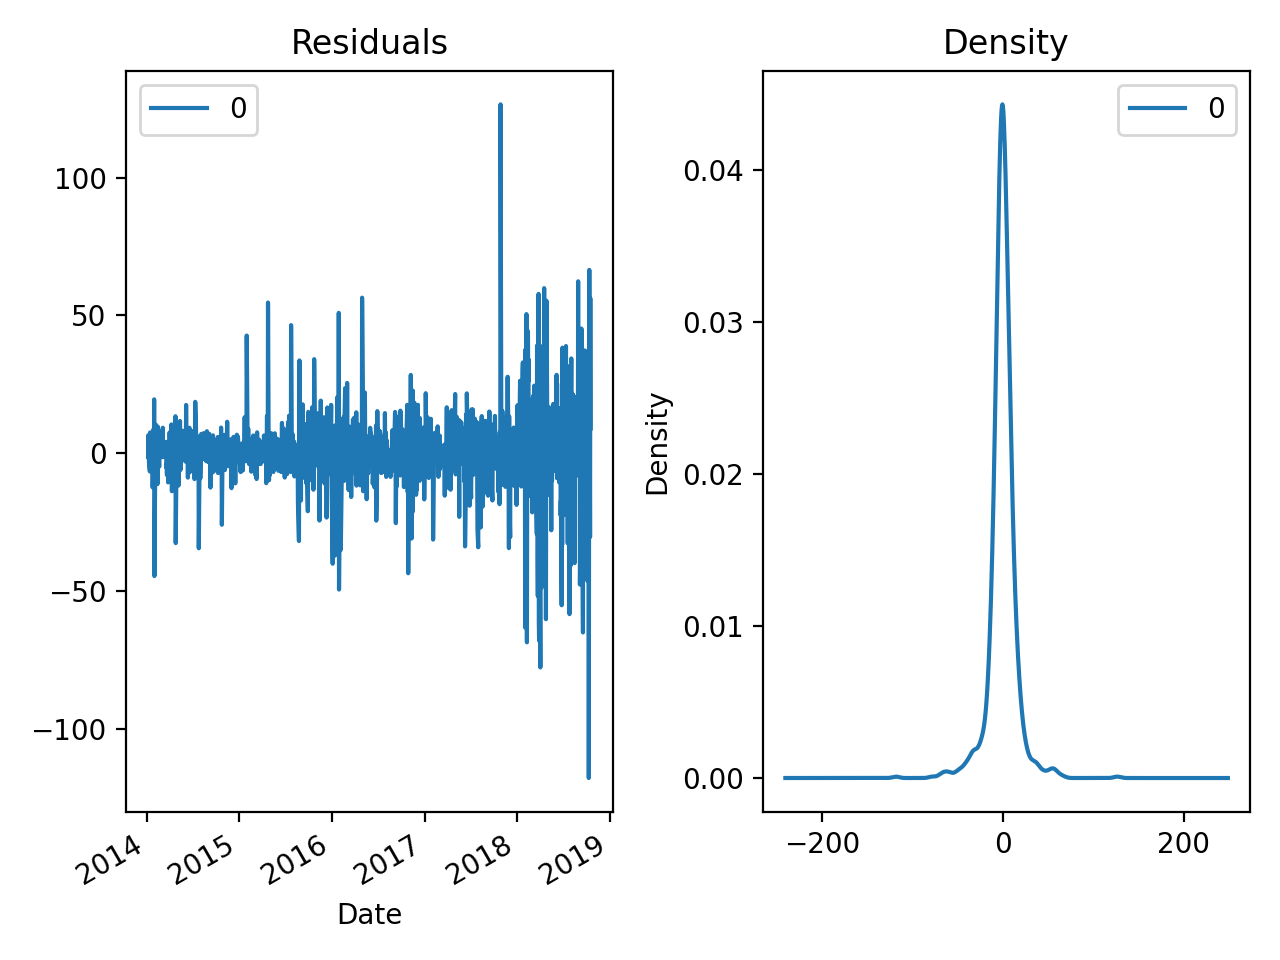

In [101]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.tight_layout()
plt.show()

The residual errors seem fine with near zero mean and uniform variance

Now, lets fit the ARIMA model with the order obtained above to our data and obtain a plot of actuals vs forecast:-

<IPython.core.display.Javascript object>


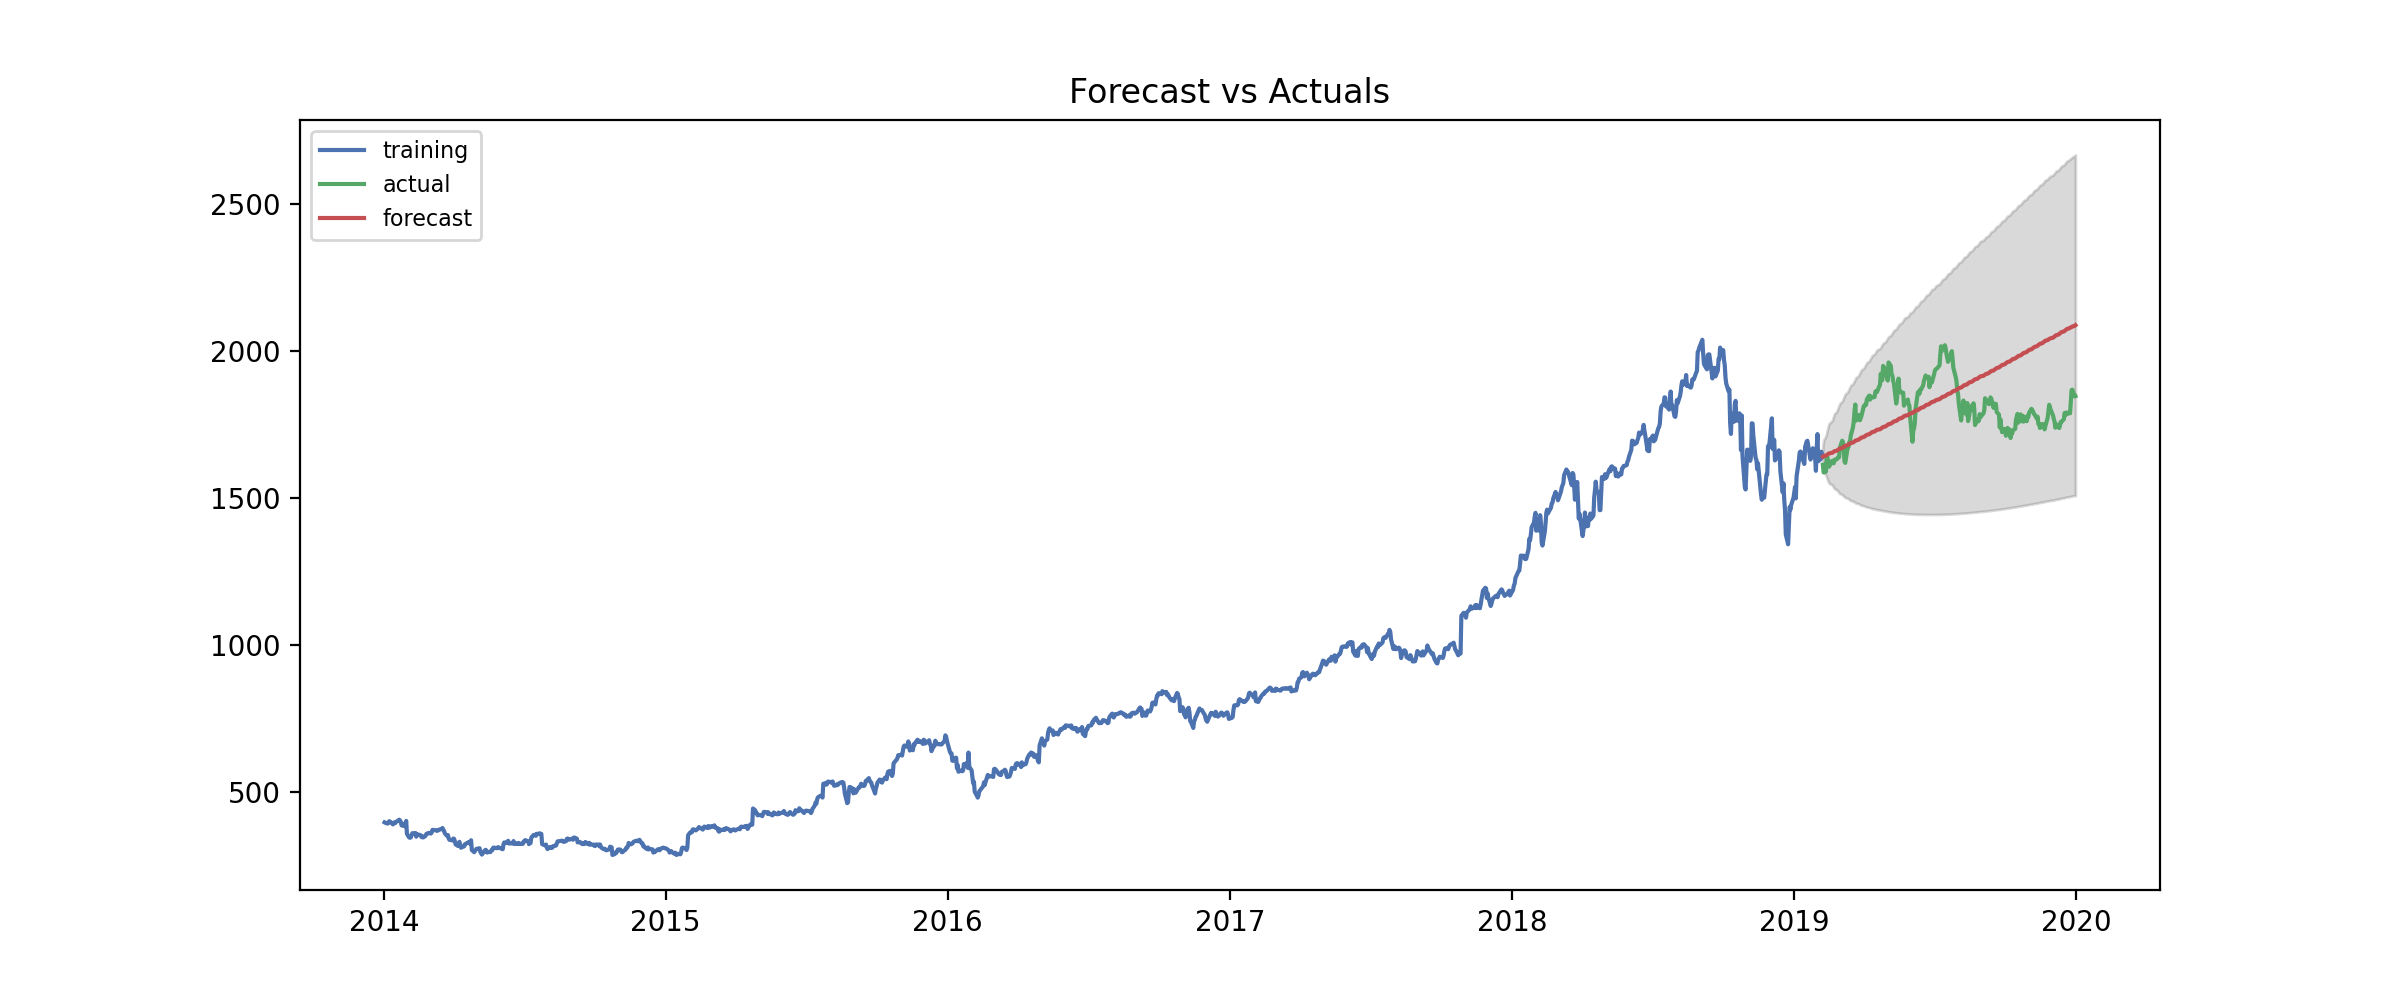

In [254]:
model = ARIMA(train_data, order=(0,2,1))
model_fit = model.fit() 

# Forecast
forecast, standard_error , confidence = model_fit.forecast(n_test, alpha=0.05)  # 95% conf

fc_series = pd.Series(forecast, index = test_data[:n_test].index)
lower_series = pd.Series(confidence[:, 0], index = test_data[:n_test].index)
upper_series = pd.Series(confidence[:, 1], index = test_data[:n_test].index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

From the chart, the ARIMA(2,2,2) model seems to give a directionally correct forecast. And the actual observed values lie within the 95% confidence band. That seems fine.

But most of the predicted forecasts are somewhat below the actuals. So, the accuracy can still be improved

**Experiment with various values of p and q to see which model gives least AIC and also look for a graph that gives closer actuals and forecasts**

You may look at this tutorial later for reference of detailed time series analysis ( https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)

We will move on to Portfolio optimization now, which is an interesting concept as well

# Portfolio Optimization:-

In portfolio optimization, we seek the best way to invest some capital in a set of $n$ assets which gives returns as $x_1$, $x_2$,.., $x_n$.

Let $w_i$ be the weight assigned to stock $x_i$ in the portfolio allocation. Hence our problem becomes:-

$\max E(\sum_i w_i*x_i)$ <br>
$\sum_i w_i = 1$



Often, while constructing a portfolio, we try to maximize the risk adjusted return. Metric used for that is **Sharpe Ratio**

Sharpe ratio is the measure of risk-adjusted return of a financial portfolio. A portfolio with a higher Sharpe ratio is considered superior relative to its peers. Sharpe ratio is calculated as follows:-

$\text{Sharpe Ratio} = \frac{(R_p - R_f)}{s_f}$

where $R_p$ is the return of the portfolio, $R_f$ is the risk free return, and $s_f$ is the standard deviation of the returns of portfolio

Let us take a look at constructing a portfolio allocation of stock of some tech companies:-

First we will start with a basic portfolio to illustrate the concept and then we will move on to optimize the portfolio by finding the optimal weights

In [245]:
weights = np.array([0.25,0.25,0.25,0.25])

In [244]:
FAANG_data = pdr.get_data_yahoo("AAPL AMZN GOOG MSFT", start="2019-01-01", end="2020-01-01").Close
FAANG_data.head()

[*********************100%***********************]  4 of 4 completed


,AAPL,AMZN,GOOG,MSFT
Date,,,,
2019-01-02,39.480000,1539.130005,1045.849976,101.120003
2019-01-03,35.547501,1500.280029,1016.059998,97.400002
2019-01-04,37.064999,1575.390015,1070.709961,101.930000
2019-01-07,36.982498,1629.510010,1068.390015,102.059998
2019-01-08,37.687500,1656.579956,1076.280029,102.800003


In [246]:
returns = FAANG_data.pct_change() #calculating daily returns

In [247]:
cov_matrix_annual = returns.cov()*252

# we are multiplying by 252 because thats the number of trading days in a year, and we are calculating annual return
cov_matrix_annual

,AAPL,AMZN,GOOG,MSFT
AAPL,0.068815,0.035618,0.035386,0.032437
AMZN,0.035618,0.052122,0.033647,0.032870
GOOG,0.035386,0.033647,0.058436,0.030212
MSFT,0.032437,0.032870,0.030212,0.039689


In [248]:
# Calculate the portfolio variance
port_variance = np.dot(weights.T,np.dot(cov_matrix_annual,weights))

# see the power of numpy above in matrix multiplication, we didn't have to write for loops

port_std = np.sqrt(port_variance)
port_std

0.19675478406504637

In [249]:
port_mean_annual_return = np.sum(returns.mean()*weights)*252
port_mean_annual_return

0.4024119047867672

We can see above that this portfolio has an expected return of $40 \%$ with a volatility of $19 \%$

Lets optimize the portfolio now to see the optimal weight allocation, where we will maximize for sharpe ratio

We will be making use of **pypfopt** package:-

Documentation :- https://pyportfolioopt.readthedocs.io/en/latest/MeanVariance.html

In [250]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

In [252]:
# Portfolio Optimization

# Calculate the expected returns and the annualized sample covariance matrix of asset returns
mean = expected_returns.mean_historical_return(FAANG_data)
cov = risk_models.sample_cov(FAANG_data)

# Optimize for maximum sharpe ratio
ef = EfficientFrontier(mean,cov,weight_bounds=(0,1))
ef.add_constraint(lambda w: w[0]+w[1]+w[2]+w[3] == 1)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights() 
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('AAPL', 0.61551), ('AMZN', 0.0), ('GOOG', 0.0), ('MSFT', 0.38449)])
Expected annual return: 74.8%
Annual volatility: 21.7%
Sharpe Ratio: 3.35


(0.7480513428401947, 0.2174644895622414, 3.347909096817465)

Lets now try to plot the efficient frontier:-

The efficient frontier is the set of optimal portfolios that offer the highest expected return for a defined level of risk or the lowest risk for a given level of expected return. Portfolios that lie below the efficient frontier are sub-optimal because they do not provide enough return for the level of risk. Portfolios that cluster to the right of the efficient frontier are sub-optimal because they have a higher level of risk for the defined rate of return.



<IPython.core.display.Javascript object>


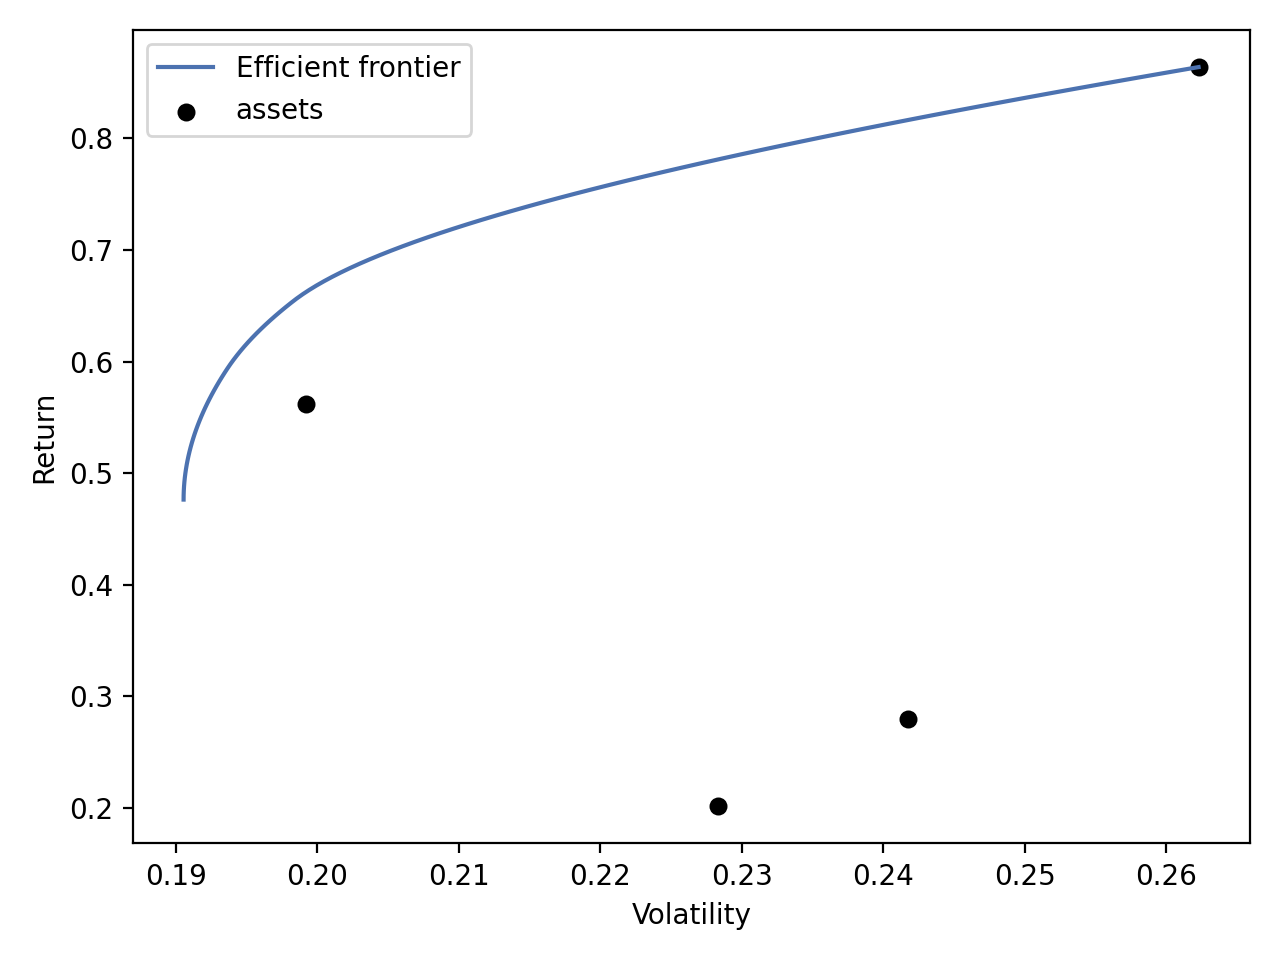

Expected annual return: 74.8%
Annual volatility: 21.7%
Sharpe Ratio: 3.35


(0.7480513428401947, 0.2174644895622414, 3.347909096817465)

In [253]:
mean = expected_returns.mean_historical_return(FAANG_data)
cov = risk_models.sample_cov(FAANG_data)

# Optimize for maximum sharpe ratio
ef = EfficientFrontier(mean,cov,weight_bounds=(0,1))
ef.add_constraint(lambda w: w[0]+w[1]+w[2]+w[3] == 1)
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights() 
ef.portfolio_performance(verbose=True)
